In [30]:
print('-------> Tested under the following settings:')
import scipy
print('SciPy version :', scipy.__version__)
import numpy
print('NumPy version :', numpy.__version__)
import matplotlib
print('Matplotlib version :', matplotlib.__version__)
import brian2
print('Brian2 version :', brian2.__version__)

-------> Tested under the following settings:
SciPy version : 1.9.1
NumPy version : 1.21.6
Matplotlib version : 3.5.2
Brian2 version : 2.5.1


In [31]:
TF1 = np.load("data/RS-cell_CONFIG1_fit.npy")

In [23]:
TF1


array([-5.28798271e-02,  6.33942992e-03, -6.24385158e-04,  4.53864113e-04,
       -5.35849598e-04,  5.28552674e-04, -4.12368909e-03, -2.95888703e-04,
       -5.89744464e-05,  2.15746551e-04,  1.87178819e-03])

In [32]:
# displaying figures inline:
%matplotlib inline 

In [33]:
# the parameters are written within a library of neuron parameters
from modeling_mesoscopic_dynamics.single_cell_models.cell_library import get_neuron_params
RS_params = get_neuron_params('RS-cell', name='RS-cell', SI_units=False)
print(RS_params)

cell parameters --NOT-- in SI units
{'name': 'RS-cell', 'N': 1, 'Gl': 10.0, 'Cm': 200.0, 'Trefrac': 5.0, 'El': -65.0, 'Vthre': -50.0, 'Vreset': -65.0, 'delta_v': 2.0, 'a': 4.0, 'b': 20.0, 'tauw': 500.0}


In [34]:
# the parameters are written within a library of neuron parameters
from modeling_mesoscopic_dynamics.single_cell_models.cell_library import get_neuron_params
FS_params = get_neuron_params('FS-cell', name='FS-cell', SI_units=False)
print(FS_params)

cell parameters --NOT-- in SI units
{'name': 'FS-cell', 'N': 1, 'Gl': 10.0, 'Cm': 200.0, 'Trefrac': 5.0, 'El': -65.0, 'Vthre': -50.0, 'Vreset': -65.0, 'delta_v': 0.5, 'a': 0.0, 'b': 0.0, 'tauw': 1000000000.0}


In [5]:
# Note that we also used the network parameters because it requires the synaptic properties (number of synapses)
# they are stored in the following module
from modeling_mesoscopic_dynamics.synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
print(get_connectivity_and_synapses_matrix('CONFIG1'))

synaptic network parameters --NOT-- in SI units
[[{'p_conn': 0.05, 'Q': 1.0, 'Tsyn': 5.0, 'Erev': 0.0, 'name': 'ee', 'Ntot': 10000, 'gei': 0.2, 'ext_drive': 4.0, 'afferent_exc_fraction': 1.0}
  {'p_conn': 0.05, 'Q': 1.0, 'Tsyn': 5.0, 'Erev': 0.0, 'name': 'ei'}]
 [{'p_conn': 0.05, 'Q': 5.0, 'Tsyn': 5.0, 'Erev': -80.0, 'name': 'ie'}
  {'p_conn': 0.05, 'Q': 5.0, 'Tsyn': 5.0, 'Erev': -80.0, 'name': 'ii'}]]


In [35]:
from mean_field.euler_method import run_mean_field_extended

ModuleNotFoundError: No module named 'mean_field'

In [36]:
import argparse
# First a nice documentation 
parser=argparse.ArgumentParser(description=
 """ 
 ----------------------------------------------------------------------
 Run the a network simulation using brian2

 Choose CELLULAR and NTWK PARAMETERS from the available libraries
 see  ../synapses_and_connectivity.syn_and_connec_library.py for the CELLS
 see ../synapses_and_connectivity.syn_and_connec_library.py for the NTWK

 Then construct the input as "NRN_exc--NRN_inh--NTWK"
 example: "LIF--LIF--Vogels-Abbott"
 ----------------------------------------------------------------------
 """
,formatter_class=argparse.RawTextHelpFormatter)

parser.add_argument("--CONFIG",help="Cell and Network configuration !", default='RS-cell--FS-cell--CONFIG1')
parser.add_argument("--afferent_exc_fraction",help="stimulation amplitude in Hz", type=float, default=0.)
parser.add_argument("--amp",help="stimulation amplitude in Hz", type=float, default=2.)
parser.add_argument("--t0",help="stimulation middle point in ms", type=float, default=800.)
parser.add_argument("--T1",help="stimulation rise time in ms", type=float, default=60.)
parser.add_argument("--T2",help="stimulation rise time in ms", type=float, default=100.)
parser.add_argument("--DT",help="time steps in ms", type=float, default=0.1)
parser.add_argument("--tstop",help="time of simulation in ms", type=float, default=1200.)
parser.add_argument("--kick_duration",help=" stimulation duration (ms) for the initial kick",\
                    type=float, default=20.)
parser.add_argument("--SEED",help="SEED for the simulation", type=int, default=5)
parser.add_argument("-f", "--file",help="filename for saving",\
                    default='data/waveform_input_example.npy')
parser.add_argument("--n_rec",help="number of recorded neurons", type=int, default=3)
parser.add_argument('-S', "--sim",action='store_true') # FOR SIMULATION

args = parser.parse_args()

In [37]:
from modeling_mesoscopic_dynamics.mean_field.euler_method import *

In [38]:
args.file

'/home/maria/.local/share/jupyter/runtime/kernel-d631eed5-402e-402b-9740-36de37af4d70.json'

In [39]:
zoom_conditions=[args.t0-5*args.T1, args.tstop]
raster_number=400


time_array, rate_array, rate_exc, rate_inh,\
        Raster_exc, Raster_inh,\
        Vm_exc, Vm_inh, Ge_exc, Ge_inh, Gi_exc, Gi_inh = np.load(args.file, allow_pickle=True)

if zoom_conditions is not None:
    z = zoom_conditions
else:
    z = [time_array[0],time_array[-1]]
cond_t = (time_array>z[0]) & (time_array<z[1])

###### =========================================== ######
############# adding the theoretical eval ###############
###### =========================================== ######

t0 = args.t0-4*args.T1
def rate_func(t):
    return double_gaussian(t, 1e-3*args.t0, 1e-3*args.T1, 1e-3*args.T2, args.amp)

t, fe, fi, sfe, sfei, sfi = run_mean_field_extended(args.CONFIG.split('--')[0],\
                               args.CONFIG.split('--')[1],args.CONFIG.split('--')[2],\
                               rate_func,dt=5e-4,
                               tstop=args.tstop*1e-3)


OSError: Failed to interpret file '/home/maria/.local/share/jupyter/runtime/kernel-d631eed5-402e-402b-9740-36de37af4d70.json' as a pickle

In [1]:
def heaviside(x):
    return 0.5*(1+np.sign(x))
def double_gaussian(t, t0, T1, T2, amplitude):
    return amplitude*(\
                      np.exp(-(t-t0)**2/2./T1**2)*heaviside(-(t-t0))+\
                      np.exp(-(t-t0)**2/2./T2**2)*heaviside(t-t0))


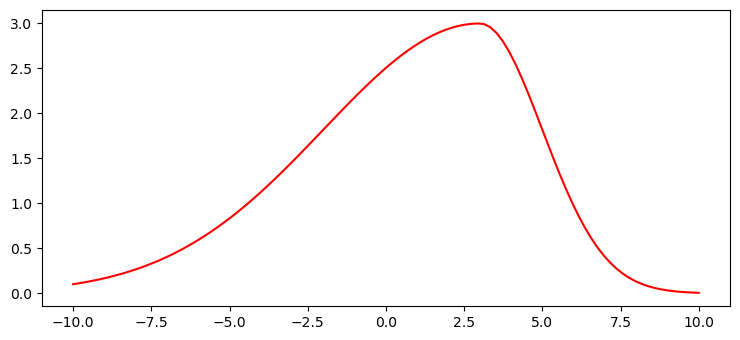

In [16]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True


x = np.linspace(-10, 10, 100)

plt.plot(x, double_gaussian(x, 3, 5, 2, 3), color='red')

plt.show()

In [1]:
def heaviside(x):
    return 0.5 * (1 + np.sign(x))
   
   
def input_rate(t, t1_exc, tau1_exc, tau2_exc, ampl_exc, plateau):
    # t1_exc=10. # time of the maximum of external stimulation
    # tau1_exc=20. # first time constant of perturbation = rising time
    # tau2_exc=50. # decaying time
    # ampl_exc=20. # amplitude of excitation
    inp = ampl_exc * (np.exp(-(t - t1_exc) ** 2 / (2. * tau1_exc ** 2)) * heaviside(-(t - t1_exc)) + \
        heaviside(-(t - (t1_exc+plateau))) * heaviside(t - (t1_exc))+ \
        np.exp(-(t - (t1_exc+plateau)) ** 2 / (2. * tau2_exc ** 2)) * heaviside(t - (t1_exc+plateau)))
    return inp


In [3]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [44]:
tau_is = np.arange(5.0, 11.0, 0.5)*1.e-3

In [45]:
tau_is

array([0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075, 0.008 , 0.0085,
       0.009 , 0.0095, 0.01  , 0.0105])

In [30]:
AmpStim=3
plat = 4000

t2 = np.arange(0, 4000, 0.1)
test_input = []

TauP=100
for ji in t2:
    test_input.append(0.+input_rate(ji, 200., TauP, TauP, AmpStim, plat))

In [35]:
np.shape(test_input)

(40000,)

In [8]:
x = np.linspace(0,10,40)

In [9]:
np.shape(x)

(40,)

In [32]:
0.07*2.4/0.3

0.56

In [34]:
np.arange(5.0, 11.0, 0.5)


array([5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

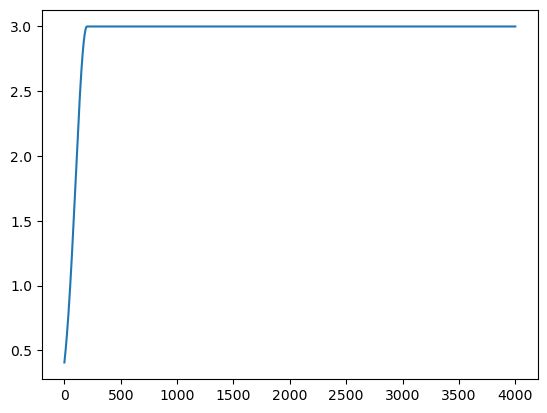

In [31]:
plt.plot(t2, test_input)

In [42]:
tfinal=4
tsteps = int(tfinal/0.0001)
t = np.linspace(0, tfinal, int(tfinal/0.0001))

In [43]:
np.shape(t)

(40000,)

Text(0.5, 0, 'time (s)')

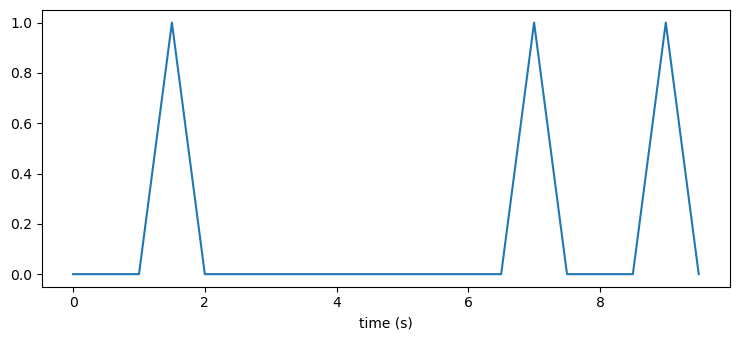

In [19]:
def homogeneous_poisson(rate, tmax, bin_size):
    nbins = np.floor(tmax/bin_size).astype(int)
    prob_of_spike = rate * bin_size
    spikes = np.random.rand(nbins) < prob_of_spike
    return spikes * 1

rate=0.315
tmax=10
lambd = rate*tmax

spikes_poisson = homogeneous_poisson(rate, tmax, bin_size)
time = np.arange(len(spikes_poisson)) * bin_size
plt.plot(time, spikes_poisson)
plt.xlabel('time (s)')

Text(0.5, 0, 'samples')

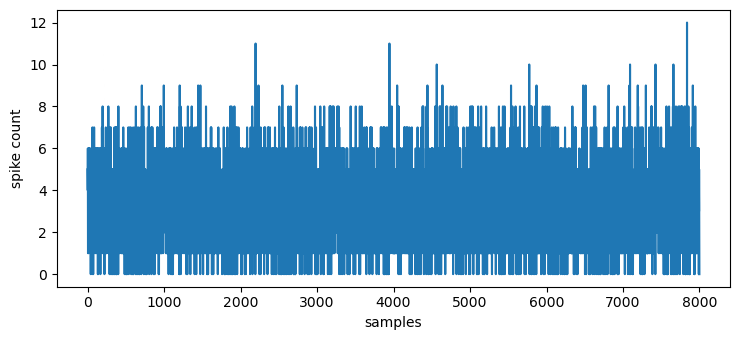

In [28]:
from scipy import stats
rate=0.315
tmax=10
lam = rate*tmax
n_spikes = stats.poisson.rvs(lam, size=8000)
     
plt.plot(n_spikes);
plt.ylabel('spike count')
plt.xlabel('samples')

In [40]:
from network_simulations.waveform_input import gaussian_func, double_gaussian
t0 = args.t0-4*args.T1
def rate_func(t):
    return double_gaussian(t, 1e-3*args.t0, 1e-3*args.T1, 1e-3*args.T2, args.amp)

t, fe, fi, sfe, sfei, sfi = run_mean_field_extended(args.CONFIG.split('--')[0],\
                               args.CONFIG.split('--')[1],args.CONFIG.split('--')[2],\
                               rate_func,dt=5e-4,
                               tstop=args.tstop*1e-3)

synaptic network parameters in SI units
synaptic network parameters in SI units
cell parameters in SI units
cell parameters in SI units
first order prediction:  [2.45017153 9.62921254]
synaptic network parameters in SI units
cell parameters in SI units
cell parameters in SI units
Make sure that those two values are similar !!
[2.45361078 9.65336353 0.09430499 0.1149737  0.24831809]
[2.45361078 9.65336353 0.09430499 0.1149737  0.24831809]
[2.45361078 9.65336353 0.09430499 0.1149737  0.24831809]
first order prediction:  0.24831808571523223
synaptic network parameters in SI units
cell parameters in SI units
cell parameters in SI units


In [ ]:
t0 = 800
T1 = 60
T2 = 100
amp = 2

In [49]:
t[-1]

1.1995

NameError: name 'set_plot' is not defined

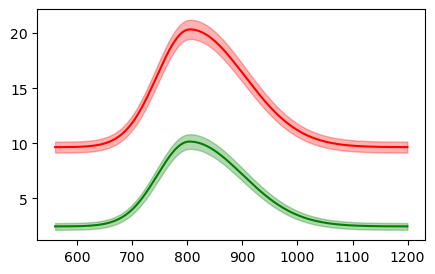

In [17]:
import matplotlib.pylab as plt
fig, AX = plt.subplots(figsize=(5,3))
"""# we bin the population rate
rate_exc = bin_array(rate_exc[cond_t], BIN, time_array[cond_t])
rate_inh = bin_array(rate_inh[cond_t], BIN, time_array[cond_t])
rate_array = bin_array(rate_array[cond_t], BIN, time_array[cond_t])
time_array = bin_array(time_array[cond_t], BIN, time_array[cond_t])

#here is the FR from the network sims
AX.plot(time_array, rate_exc, 'g-', lw=2, label='$\\nu_e(t)$')
AX.plot(time_array, rate_inh, 'r-', lw=2, label='$\\nu_i(t)$')

#I don't know what is this
AX.plot(time_array, .8*rate_exc+.2*rate_inh, 'k-', lw=2, label='$\\nu(t)$')

#This is the drive
AX.plot(1e3*t[1e3*t>t0], rate_func(t[1e3*t>t0]), 'k:',\
        lw=2, label='$\\nu_e^{aff}(t)$ \n $\\nu_e^{drive}$')"""

#The mean field predictions for exc
AX.plot(1e3*t[1e3*t>t0], fe[1e3*t>t0], 'g-', label='mean field \n pred.')
AX.fill_between(1e3*t[1e3*t>t0], fe[1e3*t>t0]-sfe[1e3*t>t0], fe[1e3*t>t0]+sfe[1e3*t>t0],\
                    color='g', alpha=.3, label='mean field \n pred.')

#The mean field predictions for inh
AX.plot(1e3*t[1e3*t>t0], fi[1e3*t>t0], 'r-', label='num. sim.')
AX.fill_between(1e3*t[1e3*t>t0], fi[1e3*t>t0]-sfi[1e3*t>t0], fi[1e3*t>t0]+sfi[1e3*t>t0],\
                    color='r', alpha=.3)
# AX.plot(1e3*t[1e3*t>t0], .8*fe[1e3*t>t0]+.2*fi[1e3*t>t0], 'k-', label='..')

# AX.legend(prop={'size':'xx-small'})

set_plot(AX, ['left'], ylabel='$\\nu$ (Hz)', xticks=[], num_yticks=3)

plt.show()